# Testing bias metrics and mitigation on the Adult Income dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')

from IPython.display import Markdown, display

## Importing and exploring the dataset

In [2]:
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 
                'occupation','relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
adult_df = pd.read_csv('adult/adult.data', names=column_names)
adult_df.drop(adult_df[(adult_df['race'] != ' Black') & (adult_df['race'] != ' White')].index,inplace=True)
adult_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
adult_df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,30940.000000,3.094000e+04,30940.000000,30940.000000,30940.000000,30940.000000
mean,38.668714,1.914090e+05,10.069716,1069.992211,87.734551,40.460278
std,13.685619,1.060825e+05,2.551595,7302.167330,404.123725,12.356746
min,17.000000,1.882700e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.191700e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.802815e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.384045e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [4]:
adult_df.isnull().any()

age               False
workclass         False
fnlwgt            False
education         False
education-num     False
marital-status    False
occupation        False
relationship      False
race              False
sex               False
capital-gain      False
capital-loss      False
hours-per-week    False
native-country    False
income            False
dtype: bool

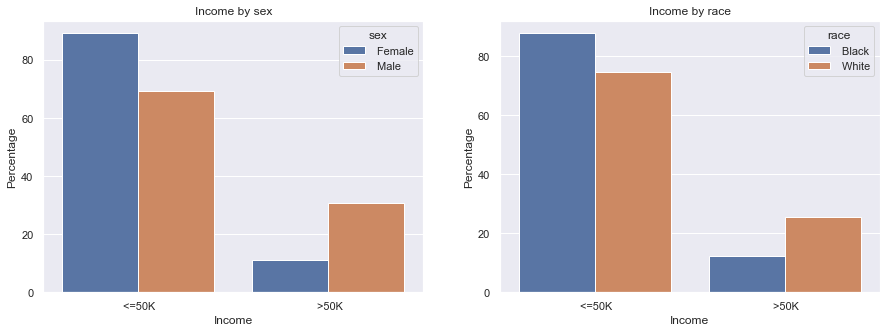

In [5]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
sns.barplot(x='income', y='percentage', 
            data=adult_df[['sex','income']].groupby('sex')['income'].value_counts(normalize=True).rename('percentage').mul(100).reset_index(),
            hue='sex',
            ax=ax[0])
sns.barplot(x='income', y='percentage', 
            data=adult_df[['race','income']].groupby('race')['income'].value_counts(normalize=True).rename('percentage').mul(100).reset_index(),
            hue='race',
            ax=ax[1])
ax[0].set(xlabel='Income', ylabel='Percentage', title="Income by sex")
ax[1].set(xlabel='Income', ylabel='Percentage', title="Income by race")
plt.show()

## Apply bias metrics and methods to the dataset

In [6]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing

In [7]:
lab_enc = LabelEncoder()
ord_enc = OrdinalEncoder()

Apply data preprocessing to transform categorical attributes to numerical attributes

In [8]:
adult_df.loc[adult_df['native-country'] == ' ?', 'native-country'] = 'Not known'
adult_df['age_class'] = pd.cut(adult_df['age'],
                               bins=[0,9,19,29,39,49,59,69,99],
                               labels=['age<10','age between 10 and 20','age between 20 and 30',
                                       'age between 30 and 40','age between 40 and 50',
                                       'age between 50 and 60','age between 60 and 70','age>70']
                              )
adult_df['hour-per-week-class'] = pd.cut(adult_df['hours-per-week'],
                               bins=[0,9,19,29,39,49,99],
                               labels=['hour<10','hours between 10 and 20','hours between 20 and 30',
                                       'hours between 30 and 40','hour between 40 and 50',
                                       'hour>70']
                              )
adult_df = adult_df.join(pd.get_dummies(adult_df['education'])).drop('education',axis=1)
adult_df = adult_df.join(pd.get_dummies(adult_df['marital-status'])).drop('marital-status',axis=1)
adult_df = adult_df.join(pd.get_dummies(adult_df['occupation'])).drop('occupation',axis=1)
adult_df = adult_df.join(pd.get_dummies(adult_df['relationship'])).drop('relationship',axis=1)
adult_df = adult_df.join(pd.get_dummies(adult_df['native-country'])).drop('native-country',axis=1)
adult_df = adult_df.join(pd.get_dummies(adult_df['age_class'])).drop('age_class',axis=1)
adult_df = adult_df.join(pd.get_dummies(adult_df['hour-per-week-class'])).drop('hour-per-week-class',axis=1)
adult_df.drop(labels=['hours-per-week','workclass','fnlwgt','capital-gain','capital-loss','age','education-num'],axis=1,inplace=True)
adult_df['income'] = lab_enc.fit_transform(adult_df['income'])
adult_df[['sex','race']] = ord_enc.fit_transform(adult_df[['sex','race']])

Create a StructuredDataset object to which apply fairness metrics and methods

In [9]:
data = BinaryLabelDataset(
    favorable_label=1, unfavorable_label=0, df=adult_df, label_names=['income'], protected_attribute_names=['sex','race'])

Split data in training, testing set and validation set

In [10]:
data_orig_train, data_orig_vt = data.split([0.7], shuffle=True)
data_orig_valid, data_orig_test = data_orig_vt.split([0.5], shuffle=True)

In [11]:
# print some informations
display(Markdown("#### Training Dataset shape"))
print(data_orig_train.features.shape)
display(Markdown("#### Protected attribute names"))
print(data_orig_train.protected_attribute_names)
display(Markdown("#### Favorable and unfavorable labels"))
print(data_orig_train.favorable_label, data_orig_train.unfavorable_label)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(data_orig_train.privileged_protected_attributes, 
      data_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(data_orig_train.feature_names)

#### Training Dataset shape

(21658, 101)


#### Protected attribute names

['sex', 'race']


#### Favorable and unfavorable labels

1.0 0.0


#### Privileged and unprivileged protected attribute values

[array([1.]), array([1.])] [array([0.]), array([0.])]


#### Dataset feature names

['race', 'sex', ' 10th', ' 11th', ' 12th', ' 1st-4th', ' 5th-6th', ' 7th-8th', ' 9th', ' Assoc-acdm', ' Assoc-voc', ' Bachelors', ' Doctorate', ' HS-grad', ' Masters', ' Preschool', ' Prof-school', ' Some-college', ' Divorced', ' Married-AF-spouse', ' Married-civ-spouse', ' Married-spouse-absent', ' Never-married', ' Separated', ' Widowed', ' ?', ' Adm-clerical', ' Armed-Forces', ' Craft-repair', ' Exec-managerial', ' Farming-fishing', ' Handlers-cleaners', ' Machine-op-inspct', ' Other-service', ' Priv-house-serv', ' Prof-specialty', ' Protective-serv', ' Sales', ' Tech-support', ' Transport-moving', ' Husband', ' Not-in-family', ' Other-relative', ' Own-child', ' Unmarried', ' Wife', ' Cambodia', ' Canada', ' China', ' Columbia', ' Cuba', ' Dominican-Republic', ' Ecuador', ' El-Salvador', ' England', ' France', ' Germany', ' Greece', ' Guatemala', ' Haiti', ' Holand-Netherlands', ' Honduras', ' Hong', ' Hungary', ' India', ' Iran', ' Ireland', ' Italy', ' Jamaica', ' Japan', ' Mexico

### Compute bias metric on the original training data 

In [12]:
unpriv_group = [{'sex': 0, 'race':0}]
priv_group = [{'sex': 1, 'race':1}]

In [13]:
bm = BinaryLabelDatasetMetric(data_orig_train, 
                              privileged_groups=priv_group, 
                              unprivileged_groups=unpriv_group)

Compute the _disparate impact_ metric defined as:
$$
\frac{Pr(Y=1|D=unprivileged)}{Pr(Y=1|D=privileged)}
$$

In [14]:
print("Disparate Impact: %f" % bm.disparate_impact())

Disparate Impact: 0.176689


### Train and transform the original data with Reweighing

In [15]:
rw = Reweighing(unprivileged_groups=unpriv_group, privileged_groups=priv_group)
data_trans_train = rw.fit_transform(data_orig_train)

Compute the same metrics on the transformed data

In [16]:
bm = BinaryLabelDatasetMetric(data_trans_train, 
                              privileged_groups=priv_group, 
                              unprivileged_groups=unpriv_group)

In [17]:
print("Disparate Impact: %f" % bm.disparate_impact())

Disparate Impact: 1.000000


The disparate impact is removed.

In [18]:
data_trans_train.instance_weights

array([0.76515807, 1.        , 0.76515807, ..., 1.10956719, 1.        ,
       0.80164001])

In [19]:
np.array_equal(data_orig_train.labels, data_trans_train.labels)

True

The data labels are not changed

In [20]:
data_trans_test = rw.transform(data_orig_test)
data_trans_valid = rw.transform(data_orig_valid)

## Train and test classifier on data

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from aif360.metrics import ClassificationMetric

def compute_metrics(dataset_true, dataset_pred, 
                    unprivileged_groups, privileged_groups,
                    disp = True):
    """ Compute the key metrics """
    classified_metric_pred = ClassificationMetric(dataset_true,
                                                 dataset_pred, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metrics = OrderedDict()
    metrics["Balanced accuracy"] = 0.5*(classified_metric_pred.true_positive_rate()+
                                             classified_metric_pred.true_negative_rate())
    metrics["Statistical parity difference"] = classified_metric_pred.statistical_parity_difference()
    metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
    metrics["Average odds difference"] = classified_metric_pred.average_odds_difference()
    metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()
    metrics["Theil index"] = classified_metric_pred.theil_index()
    
    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))
    
    return metrics

### Train and test the model on unprocessed data and check the results:

In [22]:
X_train = data_orig_train.features
Y_train = data_orig_train.labels.ravel()
X_test = data_orig_test.features
Y_test = data_orig_test.labels.ravel()

In [23]:
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe_fit = pipe.fit(X_train, Y_train, logisticregression__sample_weight=data_orig_train.instance_weights.ravel())
score = cross_val_score(pipe_fit, X_test, Y_test)

In [24]:
print("Accuracy %f" % score.mean())

Accuracy 0.832579


The model has 83% of accuracy. Now compute some classification fairness metrics:

In [25]:
data_origin_pred = data_orig_valid.copy()
data_origin_pred.labels = pipe_fit.predict(data_orig_valid.features)
metrics = compute_metrics(data_orig_valid, data_origin_pred, unpriv_group, priv_group)

Balanced accuracy = 0.7350
Statistical parity difference = -0.2121
Disparate impact = 0.1771
Average odds difference = -0.1232
Equal opportunity difference = -0.1473
Theil index = 0.1387


### Train and test a model on bias processed data and check the results:

In [26]:
X_trans_train = data_trans_train.features
Y_trans_train = data_trans_train.labels.ravel()
data_trans_test = rw.transform(data_orig_test)
X_trans_test = data_trans_test.features
Y_trans_test = data_trans_test.labels.ravel()

In [27]:
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe_trans = pipe.fit(X_trans_train, Y_trans_train, logisticregression__sample_weight=data_trans_train.instance_weights.ravel())
score = cross_val_score(pipe_trans, X_trans_test, Y_trans_test, fit_params={"logisticregression__sample_weight": data_trans_test.instance_weights.ravel()})

In [28]:
print("Accuracy %f" % score.mean())

Accuracy 0.829131


In [29]:
data_trans_pred = data_trans_valid.copy()
data_trans_pred.labels = pipe_trans.predict(data_trans_valid.features)
metrics_pred = compute_metrics(data_trans_valid, data_trans_pred, unpriv_group, priv_group)

Balanced accuracy = 0.7094
Statistical parity difference = 0.0403
Disparate impact = 1.2469
Average odds difference = 0.0276
Equal opportunity difference = 0.0697
Theil index = 0.1553


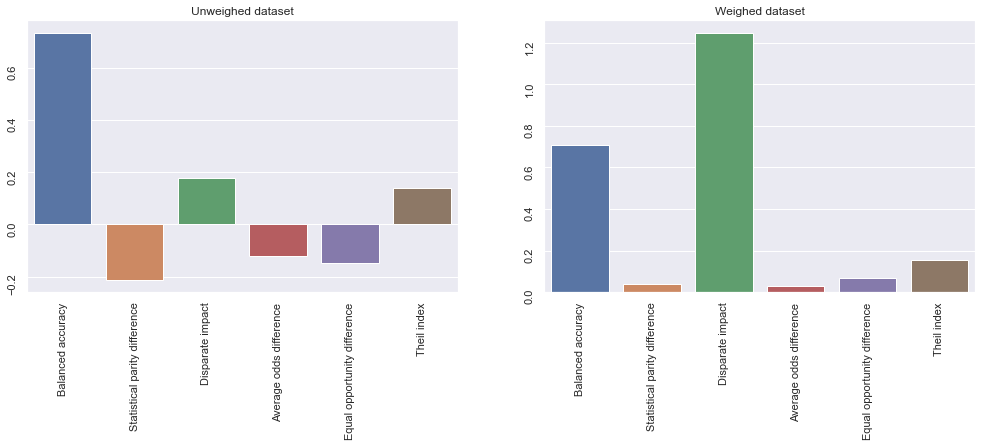

In [30]:
fig,ax = plt.subplots(1,2,figsize=(17,5))
keys = list(metrics.keys())
vals = [float(metrics[k]) for k in keys]
sns.barplot(x=keys, y=vals,ax=ax[0])
keys = list(metrics_pred.keys())
vals = [float(metrics_pred[k]) for k in keys]
sns.barplot(x=keys, y=vals,ax=ax[1])
ax[0].tick_params(labelrotation=90)
ax[1].tick_params(labelrotation=90)
ax[0].set(title='Unweighed dataset')
ax[1].tick_params(labelrotation=90)
ax[1].set(title='Weighed dataset')
plt.show()